In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/USER/ML Zoomcamp/Credit Risk Scoring/CreditScoring.csv")

In [3]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [6]:
df.status = df.status.map({1:'ok', 2:'default', 3:'unk'})

In [7]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)
 
marital_values = {
    1: 'single', 
    2: 'married', 
    3: 'widow', 
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)
 
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)
 
job_values = {
    1: 'fixed', 
    2: 'partime', 
    3: 'freelance', 
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)
 
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [9]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = (df_train.status == 'default').astype('int')
y_val = (df_val.status == 'default').astype('int')
y_test = (df_test.status == 'default').astype('int')

In [13]:
del df_train['status']
del df_val['status']
del df_test['status']

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer 
from sklearn.metrics import roc_auc_score

In [15]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [16]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [17]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [18]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
y_pred = dt.predict_proba(X_val)[:,1]

In [20]:
roc_auc_score(y_val, y_pred)

0.6703976563369138

In [21]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [22]:
y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('val:', auc)

train: 0.763427236430611
val: 0.7660925386129352


In [23]:
from sklearn.tree import export_text

In [24]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- income <= 50.50
|   |   |   |--- class: 1
|   |   |--- income >  50.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 99.50
|   |   |   |--- class: 1
|   |   |--- income >  99.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 73.50
|   |   |   |--- class: 0
|   |   |--- income >  73.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- time <= 27.00
|   |   |   |--- class: 0
|   |   |--- time >  27.00
|   |   |   |--- class: 1



C:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
for d in [1,2,3,4,5,6,10, 15, 20, None]:
    for t in [1,2,5,10,15,20,100,200]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=t)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        print('%s, %s -> %.3f'%(d,t,auc))

1, 1 -> 0.613
1, 2 -> 0.613
1, 5 -> 0.613
1, 10 -> 0.613
1, 15 -> 0.613
1, 20 -> 0.613
1, 100 -> 0.613
1, 200 -> 0.613
2, 1 -> 0.688
2, 2 -> 0.688
2, 5 -> 0.688
2, 10 -> 0.688
2, 15 -> 0.688
2, 20 -> 0.688
2, 100 -> 0.688
2, 200 -> 0.688
3, 1 -> 0.763
3, 2 -> 0.763
3, 5 -> 0.763
3, 10 -> 0.763
3, 15 -> 0.763
3, 20 -> 0.763
3, 100 -> 0.756
3, 200 -> 0.753
4, 1 -> 0.779
4, 2 -> 0.779
4, 5 -> 0.779
4, 10 -> 0.774
4, 15 -> 0.771
4, 20 -> 0.784
4, 100 -> 0.767
4, 200 -> 0.765
5, 1 -> 0.784
5, 2 -> 0.782
5, 5 -> 0.786
5, 10 -> 0.783
5, 15 -> 0.780
5, 20 -> 0.785
5, 100 -> 0.786
5, 200 -> 0.778
6, 1 -> 0.775
6, 2 -> 0.776
6, 5 -> 0.787
6, 10 -> 0.791
6, 15 -> 0.795
6, 20 -> 0.799
6, 100 -> 0.793
6, 200 -> 0.789
10, 1 -> 0.713
10, 2 -> 0.701
10, 5 -> 0.740
10, 10 -> 0.772
10, 15 -> 0.791
10, 20 -> 0.800
10, 100 -> 0.794
10, 200 -> 0.789
15, 1 -> 0.672
15, 2 -> 0.684
15, 5 -> 0.743
15, 10 -> 0.769
15, 15 -> 0.786
15, 20 -> 0.803
15, 100 -> 0.794
15, 200 -> 0.789
20, 1 -> 0.663
20, 2 -> 0.686
20

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [28]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8135545556805399

In [29]:
scores = []

for n in range(10,101,10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train) 
    
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n,auc))

In [30]:
df_scores = pd.DataFrame(scores, columns=['n_estimator', 'auc'])

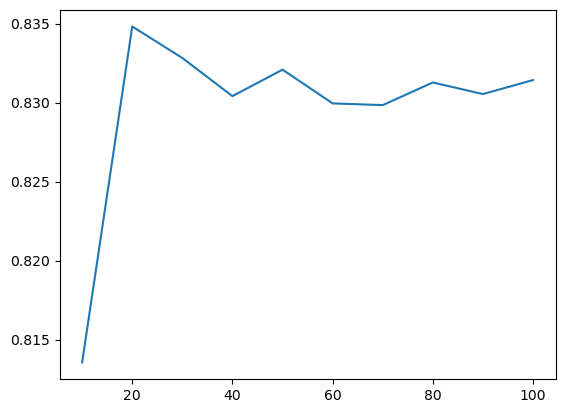

In [31]:
 plt.plot(df_scores.n_estimator, df_scores.auc)

In [32]:
scores = []

for d in [5,10,15]:
    for n in range(10,101,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train) 

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d,n,auc))

In [33]:
columns = ['depth','n_estimator', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head(n=15)

,depth,n_estimator,auc
0,5,10,0.816836
1,5,20,0.822319
2,5,30,0.821957
3,5,40,0.824540
4,5,50,0.828756
5,5,60,0.831389
6,5,70,0.831685
7,5,80,0.830919
8,5,90,0.831166
9,5,100,0.831209


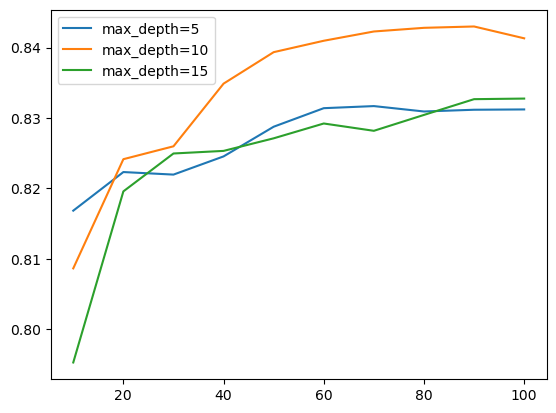

In [34]:
for d in [5,10,15]:
    df_subset = df_scores[df_scores.depth == d]
    plt.plot(df_subset.n_estimator, df_subset.auc, label='max_depth=%d' % d)

plt.legend()

In [48]:
!pip install xgboost

In [35]:
import xgboost as xgb

In [36]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
xgb_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,
    
    'objective': 'binary:logistic',
    'nthread':8,
    
    'seed':1,
    'verbosity':1
}
    


model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [38]:
y_pred = model.predict(dval)

In [39]:
roc_auc_score(y_val, y_pred)

0.8127912582355779

In [42]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [45]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth':6,
    'min_child_weight':1,
    'eval_metric':'auc',
    
    'objective': 'binary:logistic',
    'nthread':8,
    
    'seed':1,
    'verbosity':1
    
}
    


model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [48]:
def parse_xgb_output(output):
    results = []
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_scores = pd.DataFrame(results, columns=columns)
    return df_scores

In [50]:
df_score = parse_xgb_output(output)

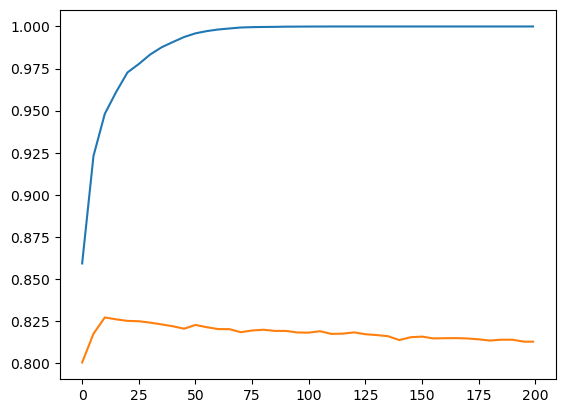

In [53]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')

In [98]:
scores = {}

In [109]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth':3,
    'min_child_weight':1,
    'eval_metric':'auc',
    
    'objective': 'binary:logistic',
    'nthread':8,
    
    'seed':1,
    'verbosity':1
    
}
    


model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [110]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output) 

In [111]:
scores.keys()

dict_keys(['max_depth=5', 'max_depth=10', 'max_depth=20', 'max_depth=3'])

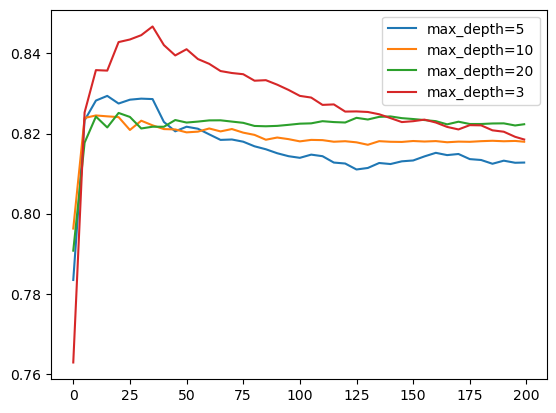

In [112]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
    
plt.legend()

In [129]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [130]:
y_pred_tree = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_tree)

0.7949480216071891

In [131]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [132]:
y_pred_forest = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_forest)

0.7949480216071891

In [125]:
xgb_params = {
    'eta': 0.1,
    'max_depth':3,
    'min_child_weight':1,
    
    'objective': 'binary:logistic',
    'nthread':8,
    
    'seed':1,
    'verbosity':1
    
}
    


model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5)

In [133]:
y_pred_xgboost = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_xgboost)

0.7949480216071891